# Main

## Librerias a utilizar

In [209]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import time
import sys
import hashlib
import ctypes

## Importando CSV

In [210]:
df_names = pd.read_table('Popular-Baby-Names-Final.csv',
                         dtype={"Name": "string"})
df_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93889 entries, 0 to 93888
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    93888 non-null  string
dtypes: string(1)
memory usage: 733.6 KB


In [211]:
df_names.sort_values(by="Name", inplace=True, ignore_index=True)
list_names = df_names.dropna().Name.to_list()
list_names = [bytes(name.encode('utf-8')) for name in list_names]

del df_names

In [212]:
sys.getsizeof(list_names)/1024

782.2109375

In [213]:
df_movie = pd.read_csv("Film-Names.csv",
                       skiprows=1,
                       names=["Name"],
                       dtype={"Name": "string"})
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    3808 non-null   string
dtypes: string(1)
memory usage: 29.9 KB


In [214]:
df_movie.replace(";","", regex=True, inplace=True)
df_movie["Name"].map(lambda x: x in list_names)
df_movie.dropna(subset=["Name"], inplace=True)
df_movie.sort_values(by="Name",ignore_index=True,inplace=True)
list_movies = df_movie.dropna().Name.to_list()
list_movies = [bytes(movie.encode('utf-8')) for movie in list_movies]

del df_movie

In [215]:
sys.getsizeof(list_movies)/1024

32.2734375

## Creando el Filtro Bloom

In [216]:
# Cargar la biblioteca compartida
lib = ctypes.CDLL('./libsearch.so')

# Definir los tipos de argumentos y retorno de la función
lib.search_string.argtypes = (ctypes.POINTER(ctypes.c_char_p), ctypes.c_int, ctypes.c_char_p)
lib.search_string.restype = ctypes.c_int

# Crea un array de strings en Python
strings = [b"hello", b"world", b"from", b"Python"]

# Convierte el array de strings en un array de punteros a caracteres utilizando ctypes
c_strings = (ctypes.c_char_p * len(strings))(*strings)

# Llamar a la función y obtener el resultado
string = b"orange"
result = lib.search_string(c_strings, len(c_strings), string)
print(result)

string = bytes("Python".encode('utf-8'))
result = lib.search_string(c_strings, len(c_strings), string)
print(result)

0
1


In [217]:
# Función que crea un arreglo con funciones de hashing, se usa como muestra el siguiente ejemplo
def create_hash_functions(k, m):
    hash_functions = []
    for i in range(k):
        def hash_function(value):
            hash_object = hashlib.sha256(str(i).encode('utf-8'))
            hash_object.update(str(value).encode('utf-8'))
            hash_value = int(hash_object.hexdigest(), 16)
            return hash_value % m
        hash_functions.append(hash_function)
    return hash_functions

#----------------------------------------
# Ejemplo de prueba:

# Se crea un arreglo con k=3 funciones hashing y largo del arreglo m=10 bits
hash_functions = create_hash_functions(3, 10)

# Conjunto de elementos de prueba
values = ["ola", "perro", "123", "xd", "aaaaaaaaaaaaaaaaahhhh"]

# Por cada elemento en values, calculo el hashing (es decir la posición en M) por cada función de hashing (en nuestro caso las funciones son k=3)
for value in values:
    hash_values = [hash_function(value) for hash_function in hash_functions]
    print(f"Value {value}: {hash_values}")

#----------------------------------------

#Intento 2 de la creación de las funciones de hashing:
def hash_generator(m):
    i = 0
    while True:
        # Define una función hash que toma un valor como entrada y devuelve un valor hash
        def hash_function(value):
            nonlocal i
            # Crea un objeto hash utilizando SHA-256 y la semilla i
            hash_object = hashlib.sha256(str(i).encode('utf-8'))
            # Actualiza el objeto hash con el valor de entrada
            hash_object.update(str(value).encode('utf-8'))
            # Obtiene el valor hash y lo convierte en un número entero
            hash_value = int(hash_object.hexdigest(), 16)
            # Incrementa la semilla i
            i += 1
            # Devuelve el valor hash módulo m
            return hash_value % m
        # Devuelve la función hash creada
        yield hash_function

# create a hash generator with range m (length of M)
m=10
hash_gen = hash_generator(10)

# generate k=3 hash functions
k = 3
hash_functions = [next(hash_gen) for _ in range(k)]

# apply each value to each hash function
values = ["ola", "perro", "123", "xd", "aaaaaaaaaaaaaaaaahhhh"]
for value in values:
    hash_values = [hash_function(value) for hash_function in hash_functions]
    print(f"Value {value}: {hash_values}")


Value ola: [5, 5, 5]
Value perro: [9, 9, 9]
Value 123: [8, 8, 8]
Value xd: [9, 9, 9]
Value aaaaaaaaaaaaaaaaahhhh: [2, 2, 2]
Value ola: [4, 7, 5]
Value perro: [1, 5, 8]
Value 123: [2, 3, 9]
Value xd: [6, 9, 2]
Value aaaaaaaaaaaaaaaaahhhh: [8, 4, 3]


## Creando búsquedas

In [222]:
class SearchBloomExp(ctypes.Structure):
    _fields_ = [('arrayM', ctypes.POINTER(ctypes.c_int)),
                ('listFuncHash', ctypes.POINTER(ctypes.CFUNCTYPE(ctypes.c_char_p))),
                ('db', ctypes.POINTER(ctypes.c_char_p))]

    def __init__(self, database: np.ndarray[str], num_funct_hash: int, size_array_M: int) -> None:
        self.arrayM = (ctypes.c_int * size_array_M)()
        hash_gen = hash_generator(size_array_M)
        self.listFuncHash = (ctypes.CFUNCTYPE(ctypes.c_uint) * num_funct_hash)(*([next(hash_gen) for _ in range(num_funct_hash)]))
        self.db = (ctypes.c_char_p * len(database))(*database)
        # train function hash
        for x in self.db:
            list_index = [f_hash(x) for f_hash in self.listFuncHash]
            for y in list_index:
                self.arrayM[y] = 1
            
        
    def busqueda_sin_filtro(self, texto: str) -> bool:
        c_strings = (ctypes.c_char_p * len(self.db))(*self.db)
        return bool(lib.search_string(c_strings, len(c_strings), bytes(texto.encode('utf-8'))))
    
    def filtro_bloom(self, texto: str) -> bool:
        # Obtenemos
        list_index = [f_hash(texto) for f_hash in self.listFuncHash]
        return bool(np.array([self.arrayM[y] for y in list_index]).prod())

## Experimentos

In [226]:
import ctypes
import numpy as np

# define structure
class SearchBloomExp(ctypes.Structure):
    _fields_ = [('arrayM', ctypes.POINTER(ctypes.c_int)),
                ('listFuncHash', ctypes.POINTER(ctypes.CFUNCTYPE(ctypes.c_uint, ctypes.c_char_p))),
                ('db', ctypes.POINTER(ctypes.c_char_p)),
                ('num_funct_hash', ctypes.c_uint32),
                ('size_array_M', ctypes.c_uint32)]

# load shared library
lib = ctypes.CDLL('./libsearch.so')

# define hash function
def hash(str):
    hash_val = 5381
    for c in str:
        hash_val = ((hash_val << 5) + hash_val) + ord(c)
    return hash_val

# define hash functions
hash_funcs = (ctypes.CFUNCTYPE(ctypes.c_uint, ctypes.c_char_p) * NUM_HASH_FUNCS)(*([lambda x: hash(x.decode('utf-8'))] * NUM_HASH_FUNCS))

# define functions
def search_string(array, length, string):
    lib.search_string.restype = ctypes.c_int
    lib.search_string.argtypes = [ctypes.POINTER(ctypes.c_char_p), ctypes.c_int, ctypes.c_char_p]
    return lib.search_string(array, length, string)

def add_to_filter(filter, string):
    for i in range(filter.num_funct_hash):
        hash_val = filter.listFuncHash[i](string.encode('utf-8')) % filter.size_array_M
        filter.arrayM[hash_val] = 1

def check_filter(filter, string):
    for i in range(filter.num_funct_hash):
        hash_val = filter.listFuncHash[i](string.encode('utf-8')) % filter.size_array_M
        if filter.arrayM[hash_val] == 0:
            return False
    return True

# define constants
NUM_HASH_FUNCS = 2
FILTER_SIZE = 1000000

# define database
database = np.array(['apple', 'banana', 'cherry', 'date', 'elderberry'], dtype=np.str)

# create filter
filter = SearchBloomExp()
filter.arrayM = (ctypes.c_int * FILTER_SIZE)()
filter.listFuncHash = hash_funcs
filter.db = (ctypes.c_char_p * len(database))(*database)
filter.num_funct_hash = NUM_HASH_FUNCS
filter.size_array_M = FILTER_SIZE

# train filter
for x in database:
    add_to_filter(filter, x)

# test filter
test_strings = ['apple', 'orange', 'pear', 'banana', 'kiwi']
for x in test_strings:
    if check_filter(filter, x):
        print(x, 'may be in the set')
    else:
        print(x, 'is not in the set')

TypeError: expected CFunctionType instance, got function

In [223]:
word_search = []
value_filter = []
value_search = []
time_filter = []
time_search = []
num_funct_hash = []
size_array = []

# Condiciones del experimento
k_max = 10
M_max = 10
seed = 1234
rng = np.random.default_rng(seed=seed)
database = list_names
data_false = list_movies
size_test = 50

# Generando conjunto de test
sample_database = rng.choice(database, size=size_test,replace=False).astype(str,copy=False)
sample_data_false = rng.choice(data_false, size=size_test,replace=False).astype(str,copy=False)

for k in range(3,k_max+1):
    for M in range(3,M_max+1):
        # Creamos un objeto que nos ayudara con los procesos internos
        test = SearchBloomExp(database=database,num_funct_hash=k+1,size_array_M=2**M)
        # Partiremos haciendo que busque elementos
        # que sabemos que estan en la base de datos
        # analizando los resultados del filtro como 
        # de buscar directamente en la base de datos
        
        word_search += [txt for txt in sample_database]
        num_funct_hash += [k for _ in sample_database]   
        size_array += [M for _ in sample_database]
        
        for name in sample_database:
            # Busqueda en el filtro   
            init_time = time.perf_counter_ns()
            res = test.filtro_bloom(name)
            time_filter.append(time.perf_counter_ns()-init_time)
            value_filter.append(res)
            # Busqueda en la DB
            init_time = time.perf_counter_ns()
            res = test.busqueda_sin_filtro(name)
            time_search.append(time.perf_counter_ns()-init_time)
            value_search.append(res)

        # Ahora analizamos los tiempos de las busquedas infrutiferas
        word_search += [txt for txt in sample_data_false]
        num_funct_hash += [k for _ in sample_data_false]   
        size_array += [M for _ in sample_data_false]
        
        for name in sample_data_false:
            # Busqueda en el filtro   
            init_time = time.perf_counter_ns()
            res = test.filtro_bloom(name)
            time_filter.append(time.perf_counter_ns()-init_time)
            value_filter.append(res)
            # Busqueda en la DB
            init_time = time.perf_counter_ns()
            res = test.busqueda_sin_filtro(name)
            time_search.append(time.perf_counter_ns()-init_time)
            value_search.append(res)
        
        # Liberamos memoria y dejamos la variable test limpia
        del test

dict_data = {"WordSearch":word_search,
             "ValueFilter":value_filter,
             "ValueSearch":value_search,
             "TimeFilter":time_filter,
             "TimeSearch":time_search,
             "NumFunctHash": num_funct_hash,
             "SizeArray": size_array,
             }

df = pd.DataFrame(dict_data)

df.to_csv("resultados.txt", index=False)

TypeError: expected CFunctionType instance, got function

# Gráficos

In [ ]:
dataset = pd.read_csv("resultados.txt", dtype={"WordSearch":"string",
                                               "ValueFilter":bool,
                                               "ValueSearch":bool,
                                               "TimeFilter":int,
                                               "TimeSearch":int,
                                               "NumFunctHash": int,
                                               "SizeArray": int,
                                               },
                      )
dataset

,WordSearch,ValueFilter,ValueSearch,TimeFilter,TimeSearch,NumFunctHash,SizeArray
0,TRINKA,True,True,45700,19386100,3,3
1,QUENTRELL,True,True,101000,18149400,3,3
2,BIRNEY,True,True,73600,17577200,3,3
3,CHANDE,True,True,75300,17660800,3,3
4,DOV,True,True,68500,17875000,3,3
...,...,...,...,...,...,...,...
6395,BEING FLYNN,True,False,114100,25472600,10,10
6396,DAVID CROSS: THE PRIDE IS BACK,True,False,95100,25878800,10,10
6397,NEVER-ENDING MAN: HAYAO MIYAZAKI,True,False,119700,25780300,10,10
6398,BILL MAHER: #ADULTING,True,False,120600,25522300,10,10


In [ ]:
dataset.dropna(inplace=True)
dataset.reset_index(drop=True,inplace=True)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   WordSearch    6400 non-null   string
 1   ValueFilter   6400 non-null   bool  
 2   ValueSearch   6400 non-null   bool  
 3   TimeFilter    6400 non-null   int32 
 4   TimeSearch    6400 non-null   int32 
 5   NumFunctHash  6400 non-null   int32 
 6   SizeArray     6400 non-null   int32 
dtypes: bool(2), int32(4), string(1)
memory usage: 162.6 KB


In [ ]:
dataset.shape[0]

6400

In [ ]:
dataset["RealTimeSearch"] = [(dataset.loc[i,"TimeFilter"] + dataset.loc[i,"TimeSearch"] if not dataset.loc[i,"ValueFilter"] else dataset.loc[i,"TimeFilter"]) for i in range(dataset.shape[0])]

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   WordSearch      6400 non-null   string
 1   ValueFilter     6400 non-null   bool  
 2   ValueSearch     6400 non-null   bool  
 3   TimeFilter      6400 non-null   int32 
 4   TimeSearch      6400 non-null   int32 
 5   NumFunctHash    6400 non-null   int32 
 6   SizeArray       6400 non-null   int32 
 7   RealTimeSearch  6400 non-null   int32 
dtypes: bool(2), int32(5), string(1)
memory usage: 187.6 KB


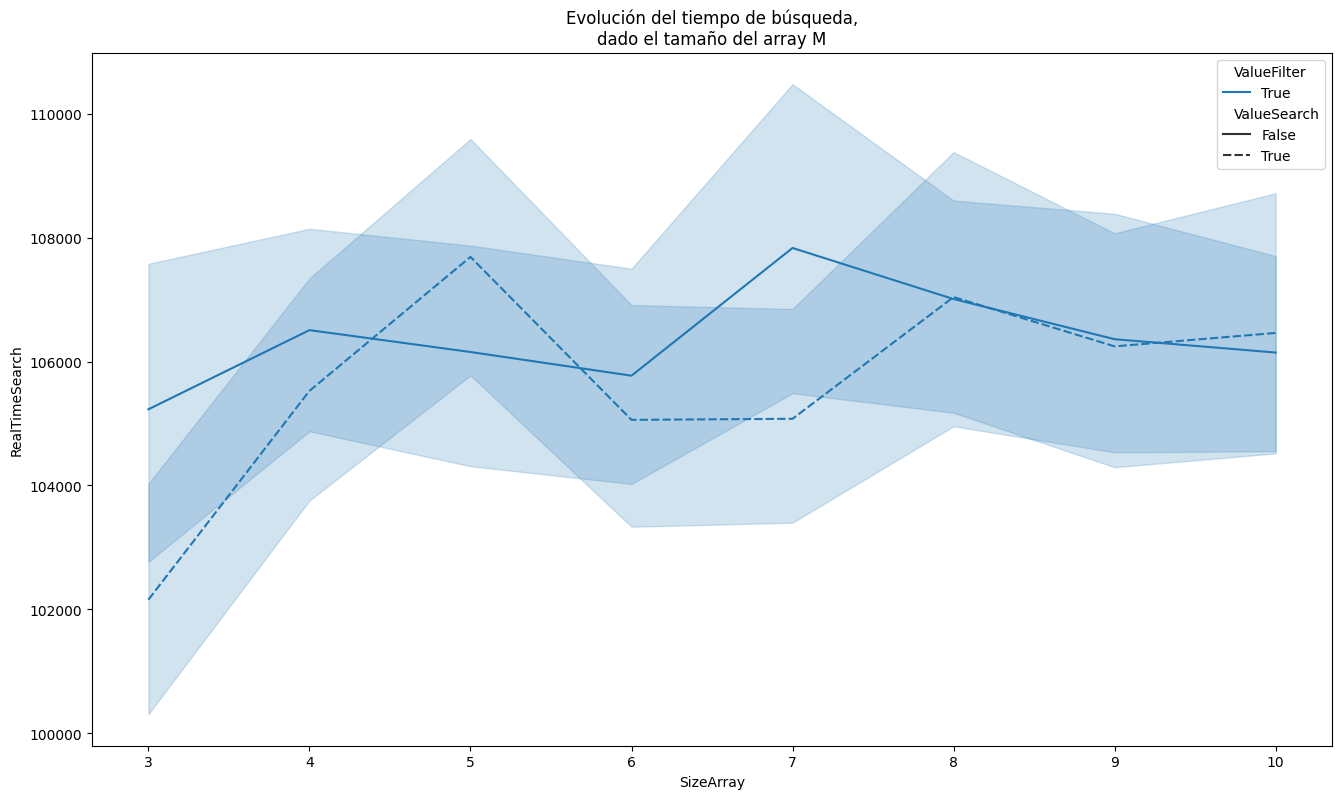

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(dataset,
             y="RealTimeSearch",
             x="SizeArray",
             hue="ValueFilter",
             style="ValueSearch",
             estimator="mean",
             ax = ax,
             )
ax.set_title("Evolución del tiempo de búsqueda,\ndado el tamaño del array M")
plt.show()

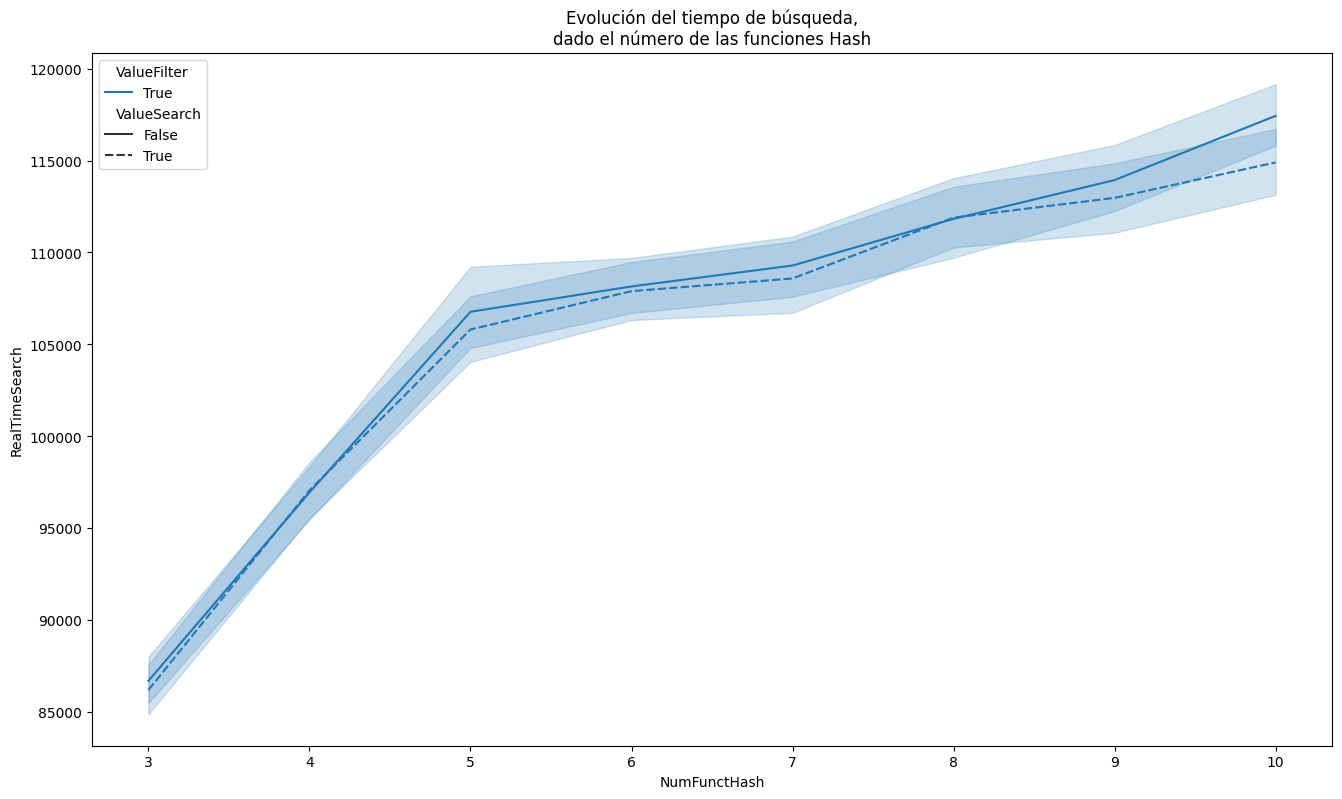

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(dataset,
             y="RealTimeSearch",
             x="NumFunctHash",
             hue="ValueFilter",
             style="ValueSearch",
             estimator="mean",
             )
ax.set_title("Evolución del tiempo de búsqueda,\ndado el número de las funciones Hash")
plt.show()

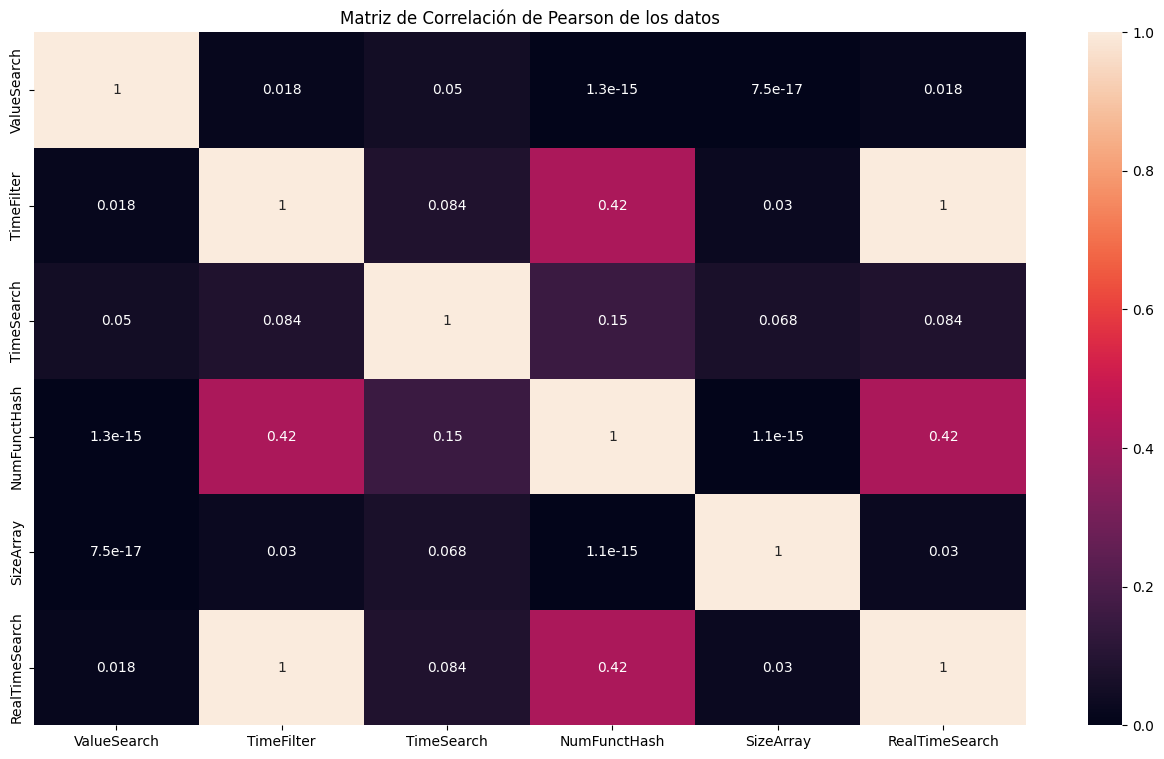

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(abs(dataset.drop(columns="ValueFilter").corr(numeric_only=True)),
            annot=True,
            ax=ax)
ax.set_title("Matriz de Correlación de Pearson de los datos")
plt.show()

In [ ]:
df_filter_bloom_stats = pd.DataFrame()

df_filter_bloom_stats["NumFunctHash"] = dataset["NumFunctHash"].unique()
df_filter_bloom_stats = df_filter_bloom_stats.merge(pd.DataFrame({"SizeArray": dataset["SizeArray"].unique()}), how="cross")
true_positive = []
false_positive = []
true_negative = []
false_negative = []
for k, M in df_filter_bloom_stats.iloc:
    df_aux = dataset[(dataset["SizeArray"] == k) &
                     (dataset["NumFunctHash"] == M)][["ValueSearch","ValueFilter"]]
    true_positive += [df_aux[(df_aux["ValueSearch"] == True) & (df_aux["ValueFilter"] == True)].shape[0]]
    false_positive += [df_aux[(df_aux["ValueSearch"] == False) & (df_aux["ValueFilter"] == True)].shape[0]]
    true_negative += [df_aux[(df_aux["ValueSearch"] == False) & (df_aux["ValueFilter"] == False)].shape[0]]
    false_negative += [df_aux[(df_aux["ValueSearch"] == True) & (df_aux["ValueFilter"] == False)].shape[0]]

df_filter_bloom_stats["TruePositive"] = true_positive
df_filter_bloom_stats["FalsePositive"] = false_positive
df_filter_bloom_stats["TrueNegative"] = true_negative
df_filter_bloom_stats["FalseNegative"] = false_negative

df_filter_bloom_stats["RateFalsePositive"] = df_filter_bloom_stats["FalsePositive"]/(df_filter_bloom_stats["FalsePositive"]+df_filter_bloom_stats["TruePositive"])
df_filter_bloom_stats["RateFalseNegative"] = df_filter_bloom_stats["FalseNegative"]/(df_filter_bloom_stats["FalseNegative"]+df_filter_bloom_stats["TrueNegative"])

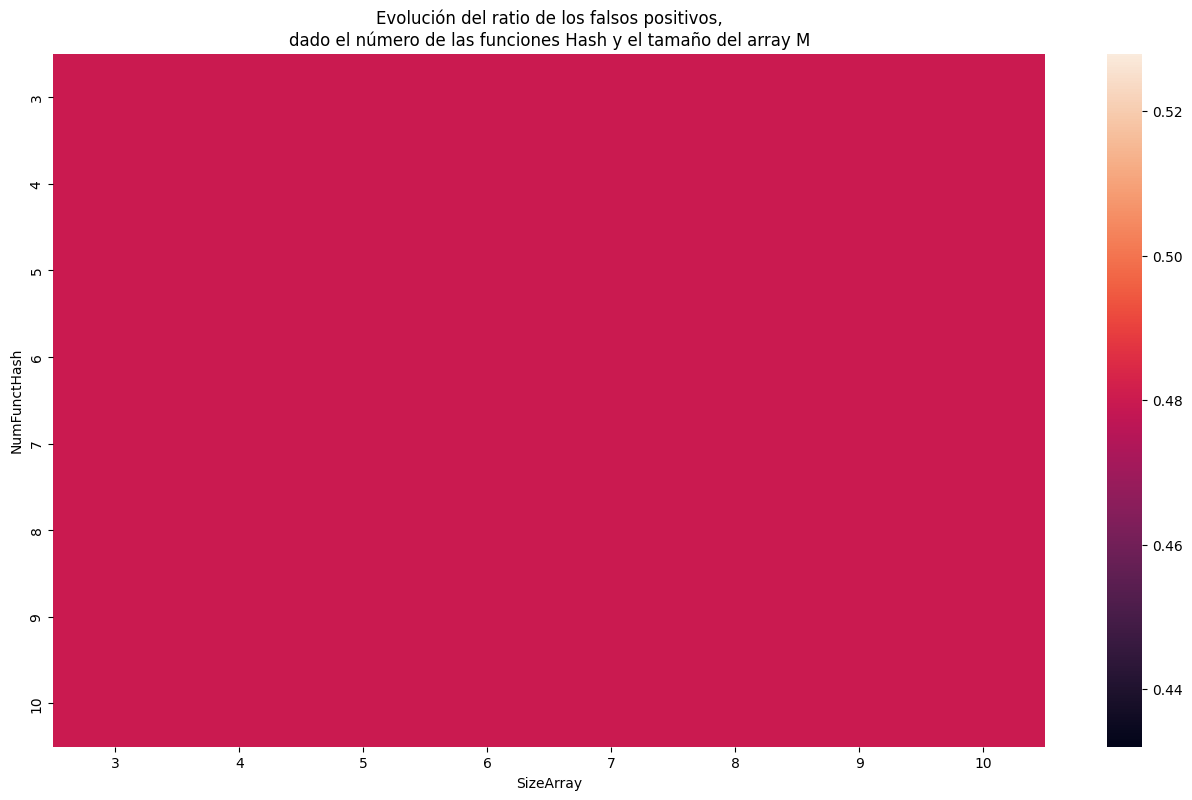

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))

sns.heatmap(df_filter_bloom_stats.pivot_table(values="RateFalsePositive", index="NumFunctHash", columns="SizeArray"),
            ax=ax)
ax.set_title("Evolución del ratio de los falsos positivos,\ndado el número de las funciones Hash y el tamaño del array M")
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

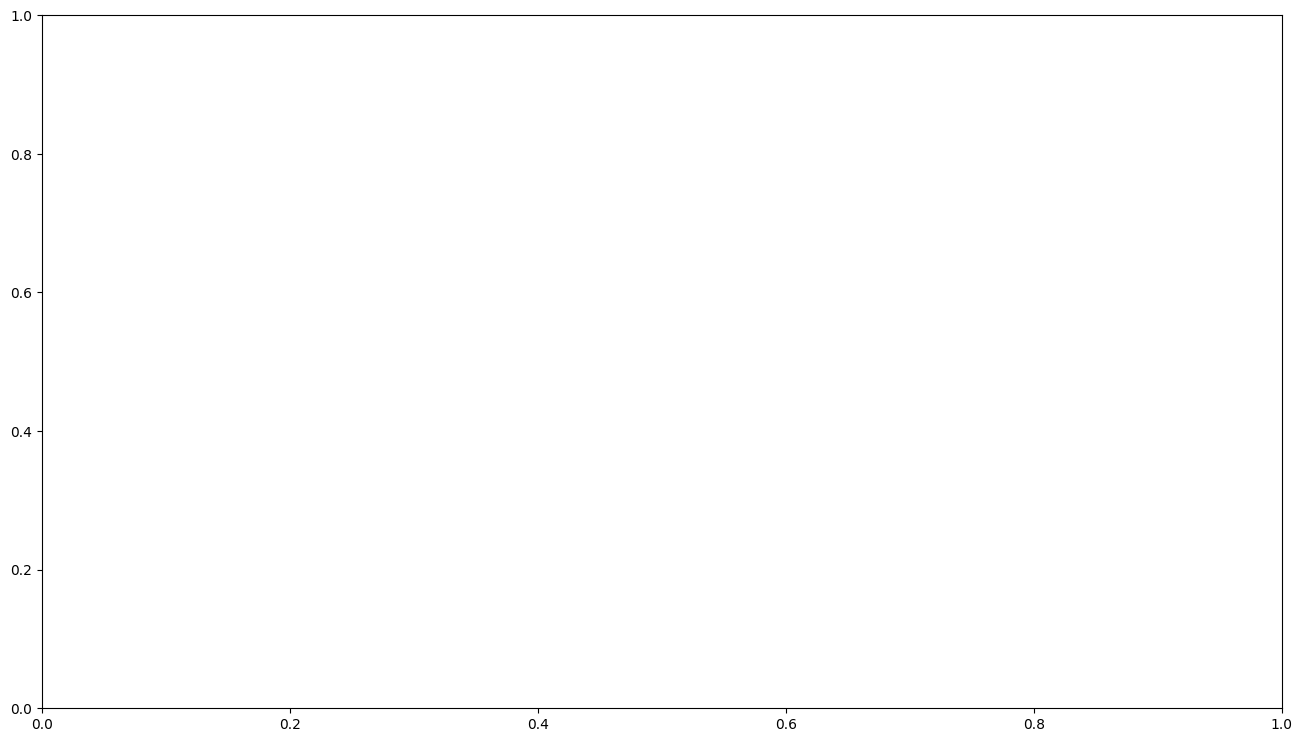

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))

sns.heatmap(df_filter_bloom_stats.pivot_table(values="RateFalseNegative", index="NumFunctHash", columns="SizeArray"),
            ax=ax)
ax.set_title("Evolución del ratio de los falsos negativos,\ndado el número de las funciones Hash y el tamaño del array M")
plt.show()